In [2]:
from tensorflow.keras import backend as K
K.clear_session()

import tensorflow as tf
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')]

In [3]:
import random
import numpy as np
from matplotlib import pyplot as plt

from tifffile import imread

from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Activation, Dropout
from tensorflow.keras.layers.experimental.preprocessing import CenterCrop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import MeanIoU

from sklearn.preprocessing import minmax_scale
from tensorflow.keras.preprocessing.image import img_to_array, load_img, save_img
from sklearn.model_selection import train_test_split

In [4]:
from configparser import ConfigParser

try:
    from google.colab import files
    
    print('upload `config.ini`')
    uploaded = files.upload()
except:
    print('no colab detected -> reading from local disk')

config = ConfigParser()
config.read('./config.ini')

no colab detected -> reading from local disk


['./config.ini']

In [5]:
import os
from pathlib import Path

try:
  from google.colab import drive
  drive.mount('/content/gdrive')
  data_path = Path(config.get('data folder', 'colab'))
except:
  import os
  from pathlib import Path
  here = Path(os.getcwd())
  data_path = here / config.get('data folder', 'taurus')

data_path = data_path.resolve()
print('getting data from {}, folders there are: {}'.format(data_path, list(os.walk(data_path))[0][1]))

getting data from /home/stefano/scratch/attila/data/toy/fluo, folders there are: ['masks', 'images']


In [6]:
def load_tiff(f):
  return imread(f)


def load_image(f):
  return load_tiff(f)


def load_mask(f):
  return load_tiff(f)


def get_data(imgs_path, masks_path):
  list_imgs = list(imgs_path.iterdir())
  
  images = []
  masks = []
 
  for img_path in list_imgs:
    img = load_image(img_path).squeeze()
    
    mask_path = str(img_path).replace(str(imgs_path), str(masks_path)).replace('img_', 'mask_')
    mask = load_mask(mask_path)
     
    images.append(np.array(img))
    masks.append(np.array(mask))

  return images, masks

In [7]:
def normalize_transformation(feature_range):
  def _f(x):
    shape = x.shape
    x = minmax_scale(x.ravel(), feature_range=feature_range)
    x = x.reshape(shape)  # original size
    return x
  
  return _f


def crop_center_transformation(shape):
  (height, width) = shape

  def get_start_point(dim, cropping):
    return dim // 2 - cropping // 2
  
  def get_end_point(start, cropping):
    return start + cropping
  
  def _f(img):
    (y, x) = img.shape
    (start_x, start_y) = (get_start_point(x, width), get_start_point(y, height))
    (end_x, end_y) = (get_end_point(start_x, width), get_end_point(start_y, height))
    return img[start_y : end_y, start_x : end_x]
  
  return _f


def rm_percentiles_transformation(min_p=0.0, max_p=100.0):
  def _f(x):
    shape = x.shape
    x = x.ravel()
    new_min, new_max = np.percentile(x, [min_p, max_p])
    x[x < new_min] = new_min
    x[x > new_max] = new_max
    return x.reshape(shape)
  
  return _f


def add_dim():
  def _f(x):
    new_dim_index = len(x.shape)
    x = np.expand_dims(x, new_dim_index)
    return x

  return _f

def compose_transformations(transformations):
  def _f(x):
    for t in transformations:
      x = t(x)
    return x
  
  return _f


def apply_transformations(lst, transformations):
  t = compose_transformations(transformations) 
  return [
    t(x) for x in lst
  ]


def do_transformations(X, y, transformations):
  X = apply_transformations(X, transformations)
  y = apply_transformations(y, transformations)
  return X, y

In [8]:
X, y = get_data(
  data_path / config.get('data folder', 'images'),
  data_path / config.get('data folder', 'masks')
)

img_shape = (config.getint('image', 'width'), config.getint('image', 'height'))
transformations = [
  np.array,  # just in case parser did not np.array-ed
  crop_center_transformation(img_shape),
  rm_percentiles_transformation(1, 98),  # threshold outliers
  normalize_transformation((0, 1)),  # pixel values in [0, 1]
  add_dim()  # keras accepts only 2D images + channels (grayscale => 1 channel)  
]
X, y = apply_transformations(X, transformations), apply_transformations(y, transformations)
X, y = np.array(X), np.array(y)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=config.getfloat('experiment', 'test size'))
print('found {} samples: {} training, {} validation'.format(len(X), len(X_train), len(X_valid)))

found 5 samples: 4 training, 1 validation


In [10]:
def plot_train_sample(X, y, ix=None):
  if ix is None:
    ix = random.randint(0, len(X) - 1)

  fig, ax = plt.subplots(1, 3, figsize=(12, 4))

  im = ax[0].imshow(X[ix, ..., 0], cmap=config.get('image', 'cmap'))
  fig.colorbar(im, ax=ax[0])
  ax[0].set_title('image')

  ax[1].hist(X[ix, ..., 0].ravel(), bins=256)
  ax[1].set_title('histogram of image')

  ax[2].imshow(y[ix].squeeze(), cmap='gray')
  ax[2].set_title('mask')
    
  return ix

def plot_pred_sample(X, y, preds, ix=None):
  if ix is None:
    ix = random.randint(0, len(X) - 1)

  fig, ax = plt.subplots(1, 2, figsize=(8, 4))
  
  im = ax[0].imshow(X[ix, ..., 0], cmap=config.get('image', 'cmap'))
  fig.colorbar(im, ax=ax[0])
  ax[0].set_title('image + mask (contour)')

  ax[1].imshow(preds[ix].squeeze(), cmap='gray')
  ax[1].contour(y[ix].squeeze(), colors='yellow', levels=[0.5])
  ax[1].set_title('predicted + original mask (contour)')

  return ix

3

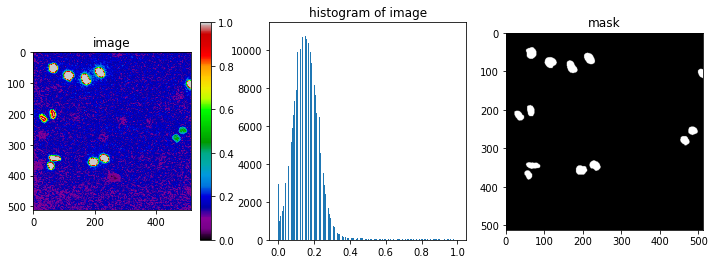

In [11]:
plot_train_sample(X_train, y_train)  # check if training data looks all right

In [12]:
def conv2d_block(n_filters, kernel_shape, padding, dropout=0.0, batchnorm=True):
  activation = 'relu'

  def _f(x):
    n_layers = 2

    for _ in range(n_layers):
      x = Conv2D(n_filters, kernel_shape, padding=padding)(x)
      
      if batchnorm:
        x = BatchNormalization()(x)
      
      x = Activation(activation=activation)(x)

      if dropout > 0:
        x = Dropout(dropout)(x)

    return x

  return _f


def contracting_block(n_filters, kernel_shape, pool_shape, padding, dropout, batchnorm):
  pooling = MaxPooling2D(pool_shape)

  def _f(x):
    x = conv2d_block(n_filters, kernel_shape, padding, dropout, batchnorm)(x)
    skip_conn = x  # save for expanding path
    x = pooling(x)  # ready for next block
    
    return x, skip_conn

  return _f


def contracting_path(n_filters, n_layers, kernel_shape, pool_shape, use_skip_conn, padding, dropout, batchnorm):
  def _f(x):
    skip_conns = []
    current_n_filters = n_filters

    for _ in range(n_layers):
      x, s = contracting_block(current_n_filters, kernel_shape, pool_shape, padding, dropout, batchnorm)(x)
    
      current_n_filters *= 2
      
      if not use_skip_conn:
        s = None  # not to be used
      
      skip_conns.append(s)

    return x, skip_conns

  return _f


def middle_path(kernel_shape, padding, dropout, batchnorm):
  def _f(x):
    n_filters = x.shape[-1] * 2
    x = conv2d_block(n_filters, kernel_shape, padding, dropout, batchnorm)(x)
    return x

  return _f


def expanding_block(n_filters, skip_conn, kernel_shape, pool_shape, padding, dropout, batchnorm):
  upsampling = UpSampling2D(pool_shape)

  def _f(x):
    x = upsampling(x)
    using_skip_conn = not (skip_conn is None)
    
    if using_skip_conn:
      s = CenterCrop(x.shape[1], x.shape[2])(skip_conn)
      x = concatenate([x, s])
    
    x = conv2d_block(n_filters, kernel_shape, padding, dropout, batchnorm)(x)
    return x

  return _f


def expanding_path(skip_conns, kernel_shape, pool_shape, padding, dropout, batchnorm):
  def _f(x):
    current_n_filters = skip_conns[-1].shape[-1]

    for skip_conn in reversed(skip_conns):
      x = expanding_block(current_n_filters, skip_conn, kernel_shape, pool_shape, padding, dropout, batchnorm)(x)
      current_n_filters /= 2

    return x

  return _f


def final_path(n_classes, activation, padding):
  def _f(x):
    x = Conv2D(n_classes, (1, 1), padding=padding, activation=activation)(x)
    return x

  return _f


def get_unet(img_shape, n_filters, n_layers, kernel_size, pool_size, n_classes, final_activation, padding, use_skip_conn, dropout=0.0, batchnorm=False):
  n_dim = 2
  kernel_shape = (kernel_size, ) * n_dim
  pool_shape = (pool_size, ) * n_dim
  
  inp = Input(img_shape)
  x = inp
  x, skip_conns = contracting_path(n_filters, n_layers, kernel_shape, pool_shape, use_skip_conn, padding, dropout, batchnorm)(x)
  x = middle_path(kernel_shape, padding, dropout, batchnorm)(x)
  x = expanding_path(skip_conns, kernel_shape, pool_shape, padding, dropout, batchnorm)(x)
  output = final_path(n_classes, final_activation, padding)(x)

  model = Model(inputs=[inp], outputs=[output])
  return model

In [14]:
def do_training(model, X_train, y_train, best_model_weights_file, training_batch_size, epochs, callbacks, compile_args):
  verbose = config.getint('experiment', 'verbose')
  
  model.compile(**compile_args)
  results = model.fit(X_train, y_train, batch_size=training_batch_size, epochs=epochs, callbacks=callbacks, validation_data=(X_valid, y_valid))
  model.load_weights(best_model_weights)
  preds_val = model.predict(X_valid, verbose=verbose)
  
  return results

def do_inference(model, best_model_weights_file, data):
  verbose = config.getint('experiment', 'verbose')
  
  model.load_weights(best_model_weights)
  preds_val = model.predict(data, verbose=verbose)
  return preds_val

In [25]:
experiments = [
  {
    'use_skip_conn': True,  # obviously
    'padding': 'same',  # usual
    'best_model_weights': 'with_same.h5',
    'results': None
  },
  {
    'use_skip_conn': False,
    'padding': 'same',  # usual
    'best_model_weights': 'without_same.h5',
    'results': None
  },
  {
    'use_skip_conn': True,  # obviously
    'padding': 'valid',
    'best_model_weights': 'with_valid.h5',
    'results': None
  },
  {
    'use_skip_conn': False,
    'padding': 'valid',
    'best_model_weights': 'without_valid.h5',
    'results': None
  }
]

base_args = {
  'img_shape': (*img_shape, config.getint('image', 'depth')),
  'n_filters': config.getint('unet', 'n filters'),
  'n_layers': config.getint('unet', 'n layers'),
  'kernel_size': 3,
  'pool_size': 2,
  'n_classes': 1,  # the other is 1 - (because it's a probability distribution)
  'final_activation': config.get('unet', 'final activation'),
  'dropout': config.getfloat('unet', 'dropout'),
  'batchnorm': config.getboolean('unet', 'batchnorm')
}

compile_args = {
  'optimizer': config.get('training', 'optimizer'),
  'loss': config.get('training', 'loss'),
  'metrics': ['accuracy', MeanIoU(num_classes=2)]  # todo re-implement
}

In [ ]:
def calc_out_size(n_layers):
  """ calculate output size in a U-Net assuming padded convolutions """

  def _div_tup(t, y):
    return (x / y for x in t)

  def _mul_tup(t, y):
    return (x * y for x in t)

  def _sub_tup(t, y):
    return (x - y for x in t)

  def _f(x):
    for _ in range(n_layers):  # contracting path
      x = _sub_tup(x, 4)  # conv
      x = _div_tup(x, 2)  # pool

    x = _sub_tup(x, 4)  # conv

    for _ in range(n_layers):  # expanding path
      x = _mul_tup(x, 2)  # upsample
      x = _sub_tup(x, 4)  # conv

    x = tuple(int(_x) for _x in x)
    return x

  return _f

def prepare_data(X_train, X_valid, y_train, y_valid, experiment):
  if experiment['padding'] == 'valid':  # we have to reduce size of output
    img_out_shape = calc_out_size(config.getint('unet', 'n layers'))(img_shape)
    output_shape = (*output_size, config.getint('image', 'depth'))

In [ ]:
for experiment in experiments:
  # prepare data
  
  
  args = {
    **base_args,
    'padding': experiment['padding'],
    'use_skip_conn': experiment['use_skip_conn']
  }

  verbose = config.getint('experiment', 'verbose')
  callbacks = [
    EarlyStopping(patience=10, verbose=verbose),  # todo what does it do?
    ReduceLROnPlateau(factor=1e-1, patience=3, min_lr=1e-5, verbose=verbose),
    ModelCheckpoint(experiment['best_model_weights'], monitor='loss', verbose=verbose, save_best_only=True, save_weights_only=True)
  ]

  model = get_unet(**args)
  experiment['results'] = do_training(
    model,
    X_train,
    y_train,
    experiment['best_model_weights'], 
    config.getint('training', 'batch size'), 
    config.getint('training', 'epochs'),  # todo try 100
    callbacks,
    compile_args
  )
  # preds = do_inference(model, experiment['best_model_weights'], X_valid)

Epoch 1/20
